# **Biodiversity Inctactness Index Change in Phoenix Arizona from 2017 to 2020**

*Author*: Melannie Moreno Rolón

For more information, you can access the GitHub repository to this project at the link [here](https://github.com/mmorenorolon/bii-change-phoenix).

## About this Notebook:

This notebook explores how biodiversity conditions have changed in Phoenix, Arizona by analyzing the Biodiversity Intactness Index (BII) between 2017 and 2020. Using Python tools for geospatial analysis, the notebook retrieves BII rasters from the Microsoft Planetary Computer, extracts the Phoenix subdivision boundary from Census TIGER/Line shapefiles, and performs a spatial overlay to quantify ecological change. The goal is to understand how urban expansion may be influencing biodiversity within the Phoenix metropolitan area.

## Highlights:

- Connect to the Microsoft Planetary Computer STAC API to access annual BII datasets.

- Calculates the percentage of land area with BII greater than 0.75 for each year.

- Visualize Phoenix within its broader geographic context using `geopandas` and basemaps from `contextily`.

- Provide a reproducible workflow for combining vector and raster data to assess ecological change.

## About the Data: Datasets Description

1. U.S. Census Bureau – County Subdivision Shapefiles (Arizona)

These shapefiles provide official geographic boundaries for county subdivisions across the United States. For this analysis, the [Arizona county subdivision](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2024.html#list-tab-790442341) dataset is used to extract the polygon representing the Phoenix subdivision. This boundary is essential for clipping the BII raster and calculating area‑based statistics. 

Date accessed: 12/06/2025
Source date: 2024

2. Biodiversity Intactness Index (BII) from the Microsoft Planetary Computer
The BII dataset estimates the proportion of biodiversity remaining in an area relative to undisturbed conditions. Values range from 0 to 1, where higher values indicate greater biodiversity intactness. The dataset is available as annual global rasters and can be accessed through the [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). This notebook uses BII rasters from 2017 and 2020 to evaluate ecological change within Phoenix, Arizona.

Date accessed: 12/06/2025
Source date: 2020


First, we will import all the necessary packages to carry out our analysis.

In [ ]:
# Import all necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  
from IPython.display import Image  # To display images
import contextily as ctx # Basemap

We wrote the following lines of code to prevent GDAL HEAD request failures. 
These environment variables ensure that GDAL can correctly read raster tiles from the Microsoft Planetary Computer. By default, GDAL attempts to issue HTTP HEAD requests when accessing remote TIFFs, but the Planetary Computer does not support these requests for secured assets. This caused reading the data to fail when clipping or plotting rasters. Setting CPL_VSIL_CURL_USE_HEAD="NO" forces GDAL to use GET requests instead, and GDAL_HTTP_VERSION="1.1" prevented HTTP errors.


In [2]:
# Prevent GDAL request failures
os.environ['CPL_VSIL_CURL_USE_HEAD'] = 'NO'
os.environ['GDAL_HTTP_VERSION'] = '1.1'

## Importing Phoenix Subdivisions Data

This section loads the Arizona county subdivision shapefile and extracts the Phoenix subdivision polygon used in the analysis.


In [3]:
# Import county subdivisions for the state of Arizona
cousub = gpd.read_file(os.path.join('data','tl_2024_04_cousub','tl_2024_04_cousub.shp'))

# Inspect the columns
cousub.columns  

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'GEOIDFQ',
       'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

After importing the Arizona county subdivision data, we subset to the county subdivision of Phoenix and set the CRS to EPSG:4326 to mach the BII dataset's CRS. Additionally, we inspected the structure, CRS, and geometry of the Phoenix subdivision to ensure it is suitable for spatial analysis.

In [5]:
# Subset to the Phoenix county subdivisions and match it to the BII CRS
phoenix = cousub[cousub['NAME'] == 'Phoenix'].to_crs('EPSG:4326') 

# View the geodataframe
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806483087,9458600,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


Within the subsetted geodataframe, we check for any missing values.

In [5]:
# Check if the dataframe has any missing values
phoenix.isnull().sum()

STATEFP     0
COUNTYFP    0
COUSUBFP    0
COUSUBNS    0
GEOID       0
GEOIDFQ     0
NAME        0
NAMELSAD    0
LSAD        0
CLASSFP     0
MTFCC       0
FUNCSTAT    0
ALAND       0
AWATER      0
INTPTLAT    0
INTPTLON    0
geometry    0
dtype: int64

After applying the `info()` method, we gained insight into the datatset's structure. It confirms that the dataset type is a geodataframe, with only 1 row and 17 variables. There are 14 variables of type `object`, 1 geometry variable, and two nuberic (integer) variables. 

In [6]:
# See informational summary about the geodataframe
phoenix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 10 to 10
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1 non-null      object  
 1   COUNTYFP  1 non-null      object  
 2   COUSUBFP  1 non-null      object  
 3   COUSUBNS  1 non-null      object  
 4   GEOID     1 non-null      object  
 5   GEOIDFQ   1 non-null      object  
 6   NAME      1 non-null      object  
 7   NAMELSAD  1 non-null      object  
 8   LSAD      1 non-null      object  
 9   CLASSFP   1 non-null      object  
 10  MTFCC     1 non-null      object  
 11  FUNCSTAT  1 non-null      object  
 12  ALAND     1 non-null      int64   
 13  AWATER    1 non-null      int64   
 14  INTPTLAT  1 non-null      object  
 15  INTPTLON  1 non-null      object  
 16  geometry  1 non-null      geometry
dtypes: geometry(1), int64(2), object(14)
memory usage: 144.0+ bytes


We later confirmed the data type of each column as seen previously. 

In [7]:
# View the data types for each column
phoenix.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

As part of the preliminary data exploration for the Phoenix county subdivision, the polygon was plotted to verify that the subset was carried out successfully.

<Axes: >

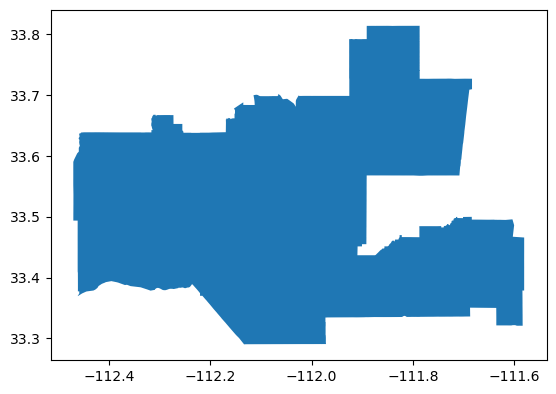

In [ ]:
# View the Phoenix county subdivision polygon
phoenix.plot()

## Phoenix Data Exploration Summary
Preliminary exploration of the Phoenix county subdivision data was conducted to confirm that the correct polygon was selected and that the geometry and attribute information were valid. The boundary was visualized to verify its geographic extent, and the dataset’s CRS was checked to ensure compatibility with the BII raster data used later in the analysis.

## Collection of Biodiversity Intactness Index (BII) 

This section will connect to the Microsoft Planetary Computer STAC catalog and search for BII rasters covering Phoenix for 2017 and 2020.

## Accessing the Microsoft Planetary Computer STAC Catalog

To obtain Biodiversity Intactness Index (BII) raster data, we first connect to the Microsoft Planetary Computer STAC catalog. The STAC API provides searchable spatiotemporal metadata that allows us to identify and retrieve geospatial datasets covering the Phoenix subdivision.

In [7]:
# Access MPC STAC catalog
catalog = Client.open(
    'https://planetarycomputer.microsoft.com/api/stac/v1',
    modifier=planetary_computer.sign_inplace,
)

## Exploring STAC Catalog Metadata

After connecting to the STAC catalog, we inspect basic metadata such as the catalog title and description to confirm successful access and to understand the scope of datasets hosted by the Microsoft Planetary Computer.

In [8]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


## Identifying the Biodiversity Intactness Index (BII) Collection

The Biodiversity Intactness Index data are stored in the `io-biodiversity` collection within the STAC catalog. In this step, we retrieve the collection object to examine its metadata and prepare for searching available raster items for the years of interest (2017 and 2020).

In [9]:
# Find the collection storing BII data
bii_collection = catalog.get_child('io-biodiversity')
bii_collection

<CollectionClient id=io-biodiversity>

## Overview of the BII Dataset

The BII dataset provides global estimates of biodiversity intactness at a 100-meter resolution. Values range from 0 to 1, with higher values indicating greater biodiversity relative to undisturbed conditions. These rasters will later be clipped to the Phoenix subdivision to quantify changes in high-intactness areas over time.

## Defining the Spatial and Temporal Extent of the Analysis

To retrieve Biodiversity Intactness Index (BII) data relevant to the Phoenix subdivision, we define both a temporal range and a spatial bounding box. The temporal range includes the years 2017 and 2020, which are used to assess changes in biodiversity intactness over time. The bounding box defines the geographic area surrounding Phoenix and limits the STAC search to rasters that intersect this region.

Using the defined spatial and temporal constraints, we search the Microsoft Planetary Computer STAC catalog for raster items in the `io-biodiversity` collection. This search returns all available BII raster items that intersect the Phoenix bounding box and correspond to the specified years.

In [10]:
#  Temporal range of interest
time_range = '2017-01-01/2020-01-01'

# Create a bounding box with the GEOJSON method
bbox = {
    'type': 'Polygon',
    'coordinates': [
        [
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574],
            [-112.826843, 32.974108]  
        ]
    ]
}

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

## Inspecting Available BII Items

To check if there were any matches in the search, we used the `item_collection()` method. This method inspects the returned items to confirm that BII raster data are available for the years of interest. This step helps verify that the search parameters were applied correctly and that the dataset contains valid results for further analysis.

In [12]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [13]:
# View the search items 
items

This output tells us there were four (4) items in the catalog that matched our search.

## Selecting BII Rasters for 2017 and 2020

From the available STAC items, we identified the BII rasters corresponding to the years 2017 and 2020. These two rasters are the basis for the BII change analysis and will be used in later steps to quantify the differences in biodiversity intactness within the Phoenix subdivision.

In [14]:
# Get items in the catalog search corresponding to the year 2020 and 2017
# Item for 2020
item_2020 = items[0]

# Item for 2017
item_2017 = items[3]

Before loading the raster data, we inspected the metadata associated with the 2017 BII item to confirm that it corresponds to the correct year and spatial reference. This way, we can verify the temporal coverage, the spatial resolution, and the coordinate reference system (CRS) prior to processing the raster.

In [15]:
# Check the 2017 item
# Print the item ID and properties
print('ID:' , item_2017.id)

# View the item's propertiess
item_2017.properties

ID: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z',
 'proj:code': 'EPSG:4326'}

We repeat the metadata inspection for the 2020 BII raster to maintain consistency with the 2017 dataset. This way, we are confirming that both rasters share the same CRS, resolution, and spatial structure necessary to support valid spatial comparisons and change analysis.

In [17]:
# Check the 2020 item
# Print the item and properties
print('ID:' , item_2020.id) 

# View the item's properties
item_2020.properties

ID: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z',
 'proj:code': 'EPSG:4326'}

To better understand the structure of the BII dataset, we inspect the metadata and available assets associated with the 2017 raster item. This includes examining item properties and identifying the available asset types (e.g., raster data, preview images, and metadata files).

In [18]:
# Inspect metadata for 2017
item_2017.properties
item_2017.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-06T07%3A44%3A20Z&se=2025-12-07T08%3A29%3A20Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-07T00%3A18%3A21Z&ske=2025-12-14T00%3A18%3A21Z&sks=b&skv=2025-07-05&sig=Ui0C4xloSkIMgv/gGgGY56Lew8KuBbCi3oQmSl6Lxw8%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97

We repeat the metadata and asset inspection for the 2020 BII raster to confirm that the available assets and structure are consistent with the 2017 dataset.

In [ ]:
# Inspect metadata for 2020
item_2020.properties
item_2020.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-06T07%3A44%3A20Z&se=2025-12-07T08%3A29%3A20Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-07T00%3A18%3A21Z&ske=2025-12-14T00%3A18%3A21Z&sks=b&skv=2025-07-05&sig=Ui0C4xloSkIMgv/gGgGY56Lew8KuBbCi3oQmSl6Lxw8%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97

To simplify the asset inspection, we list the available asset keys and their titles without displaying full URL links. This helps identify which asset corresponds to the primary raster data needed for analysis.

In [20]:
# Inspect the assets of the item in 2017 without the href links
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [21]:
# Inspect the assets of the item in 2017 without the href links
for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


## Previewing the BII Raster for 2017

Before loading the full-resolution raster data, we visualize the rendered preview of the 2017 and the 2020 BII raster provided by the STAC item. This preview offers a quick check of the spatial extent and general patterns in biodiversity intactness across the study region and helps confirm that the selected raster corresponds to the expected geographic area.

In [22]:
# Plot the rendered preview for 2017
Image(url=item_2017.assets['rendered_preview'].href, width=500)

In [23]:
# Plot the rendered preview for 2020
Image(url=item_2020.assets['rendered_preview'].href, width=500)

## Loading Full-Resolution BII Raster Data

After confirming the spatial coverage using the rendered preview, we load the full-resolution BII raster data for 2017 and 2020. These rasters contain the quantitative values needed for subsequent spatial analysis, including clipping and calculation of biodiversity intactness metrics within the Phoenix subdivision.


In [16]:
# Load the dataset using `open_rasterio()`
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

## Signing Raster Asset URLs for Remote Access

In this step, we sign the raster asset URLs so that they can be read remotely without downloading the data locally.

In [17]:
# Sign the asset URLs so they can be accessed from the Microsoft Planetary Computer
signed_2017 = planetary_computer.sign(item_2017.assets['data'].href)
signed_2020 = planetary_computer.sign(item_2020.assets['data'].href)

## Reading Raster Data Remotely Using GDAL

To avoid downloading large raster files, I used GDAL’s `/vsicurl/` virtual file system to read the signed raster assets directly from cloud storage.

In [18]:
# Open the signed raster files using the /vsicurl/ prefix so GDAL can read them remotely
bii_2017 = rioxr.open_rasterio('/vsicurl/' + signed_2017)
bii_2020 = rioxr.open_rasterio('/vsicurl/' + signed_2020)

## Inspecting the Loaded Raster Data

Once loaded, we inspected the BII rasters for both 2017 and 2020 to verify its dimensions, coordinate reference system, and overall structure.

In [ ]:
# View the bii dataset for 2017
bii_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# View the bii dataset for 2020
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## BII Data Summary

The datasets contain terrestrial biodiversity intactness index data at 100m resolution. We obtained a total of four (4) items, for which the first corresponds to the 2020 raster and the fourth, to the 2017 raster. The items have a CRS of EPSG:4326 with a scale factor of 1. 

## Phoenix Subdivision Context Map 

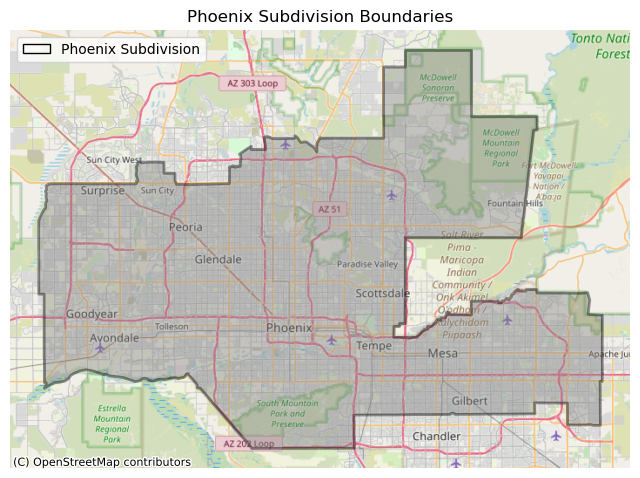

In [ ]:
# Create empty figure
fig, ax = plt.subplots(figsize=(8,8))

# Reproject the CRS
phoenix_3857 = phoenix.to_crs(epsg=3857)

# Plot the reprojected polygon
phoenix_3857.plot(ax=ax, color = 'grey', alpha = 0.4, edgecolor='k', linewidth=2)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Title
ax.set_title("Phoenix Subdivision Boundaries")

# Specify legend handles
handles = [Patch(facecolor='none', edgecolor='black', label='Phoenix Subdivision')]

ax.legend(handles=handles, loc='upper left')

# Turn off axes
ax.set_axis_off()

### Description

The map presents the Phoenix county subdivision outlined in a bold black boundary. It is situated within the broader metropolitan region of central Arizona. This map presents a geographic and administrative view of Phoenix with its urban and natural features.

## Calculating the Percentage of High BII Area in the Phoenix Subdivision

To quantify biodiversity intactness within the Phoenix subdivision, we first aligned the vector boundaries with the raster data and then restricted the analysis to pixels located within the subdivision.

### Reprojecting the Phoenix Subdivision Boundary

First, the Phoenix subdivision geometry is reprojected to match the coordinate reference system (CRS) of the BII rasters.

In [20]:
# Reproject Phoenix subdivision 
phoenix_proj = phoenix.to_crs(bii_2017.rio.crs)

Using the reprojected subdivision boundary, we clip the BII rasters for both 2017 and 2020. This step retains only raster pixels that fall within the Phoenix subdivision and removes data outside the study area.

In [21]:
# Clip the BII raster images for both years (2017 and 2020)
bii_2017_clip = bii_2017.rio.clip(phoenix_proj.geometry, phoenix_proj.crs)
bii_2020_clip = bii_2020.rio.clip(phoenix_proj.geometry, phoenix_proj.crs)

After clipping, the BII rasters now contain only pixels within the Phoenix county subdivision.

### Defining a High Biodiversity Intactness Threshold

To identify areas with relatively high biodiversity intactness, we apply a threshold of BII >= 0.75. Pixels meeting or exceeding this threshold are classified as `True`, while all other pixels are classified as `False`. This binary mask is used to quantify the proportion of land area with high biodiversity intactness.

In [41]:
# Define the BII threshold by setting it to at least 0.75. 
mask_2017 = bii_2017_clip > 0.75
mask_2020 = bii_2020_clip > 0.75

### Counting Valid Raster Pixels

After applying the threshold, we counted the total number of valid raster pixels within the Phoenix subdivision for each year.

In [42]:
# Count valid Phoenix pixels
valid_2017 = (~bii_2017_clip.isnull()).sum()
valid_2020 = (~bii_2020_clip.isnull()).sum()

We then counted the number of intact pixels defined as pixels with BII ≥ 0.75 within the Phoenix subdivision.

In [43]:
# Count the number of intact pixels
intact_2017 = mask_2017.sum()
intact_2020 = mask_2020.sum()

### Calculating the Percentage of High BII Area

The percentage of land area with high biodiversity intactness is calculated by dividing the number of intact pixels (BII >= 0.75) by the total number of valid pixels within the Phoenix subdivision and multiplying by 100.

In [44]:
# Calculate the percentage of intact pixels
pct_2017 = (intact_2017 / valid_2017 * 100).item()
pct_2020 = (intact_2020 / valid_2020 * 100).item()

In [47]:
# Compare the two percentages
print(f'The percentage of BII >= 0.75 in 2017: {pct_2017:.2f}%')
print(f'The percentage of BII >= 0.75 in 2020: {pct_2020:.2f}%')

The percentage of BII >= 0.75 in 2017: 7.13%
The percentage of BII >= 0.75 in 2020: 6.49%


Between 2017 and 2020, the proportion of the Phoenix subdivision with a Biodiversity Intactness Index (BII) of at least 0.75 declined from 7.13% to 6.49%. Although this change appears small over a three‑year period, it represents a meaningful reduction in the area of relatively intact habitat. If a decline of this magnitude were to continue steadily, it would signal a long‑term trajectory of biodiversity loss within the region. This is consistent with the pressures of rapid urban expansion and land‑use change in the Phoenix metropolitan area. Even modest annual decreases can accumulate over decades, which underscores the importance of monitoring and mitigating ecological impacts as the city grows.

## Visualizing Loss of Biodiversity

To visualize areas where biodiversity intactness declined over time, we identified pixels that met the high intactness threshold (BII >= 0.75) in 2017 but fell below this threshold by 2020. These pixels represent locations where relatively high biodiversity was lost during the study period.

A binary loss mask is created by selecting pixels that were classified as high intactness in 2017 but not in 2020. This logical comparison isolates areas where biodiversity intactness declined below the threshold between the two years.

In [ ]:
# Create the BII loss layer
mask_loss = (mask_2017) & (~mask_2020)

To visualize areas of biodiversity loss, we apply the boolean loss mask directly to the clipped 2020 BII raster using `xarray`’s `.where()` method. This operation retains raster values only at locations where biodiversity intactness was high in 2017 but fell below the threshold by 2020, and sets all other pixels to `NaN`. As a result, only loss pixels are plotted in the visualization.
To provide geographic context, the 2020 BII raster is displayed as a background layer using a continuous color scale. Areas of biodiversity loss are overlaid in red, and the Phoenix subdivision boundary is added to clearly define the study area.

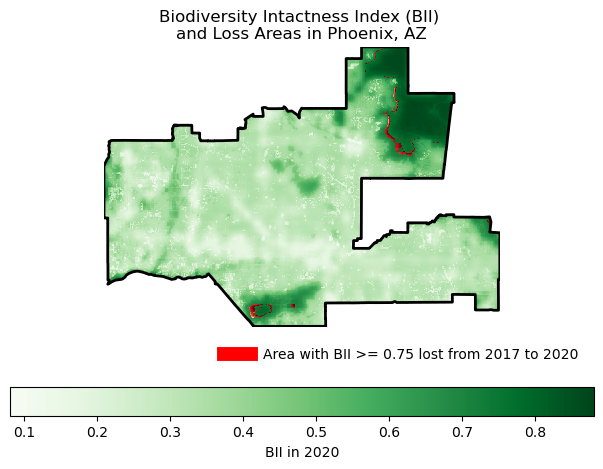

In [ ]:
# Mask 2020 BII raster to show only biodiversity loss areas
bii_loss = bii_2020_clip.where(mask_loss)

# Initialize figure
fig, ax = plt.subplots()

# Remove axes
ax.axis('off')

# Plot 2020 BII background
bii_2020_clip.squeeze().plot(ax=ax, cmap= 'Greens', cbar_kwargs = {'location': 'bottom', 'label': 'BII in 2020'})

# Plot loss mask in red
bii_loss.squeeze().plot(ax = ax, cmap = 'Reds', add_colorbar = False)


# Phoenix boundary
phoenix_proj.boundary.plot(ax = ax, color = 'black', linewidth=2)

# Create an invisible point for the legend entry
ax.plot([], [], color = 'red', linewidth = 10,
        label  = 'Area with BII >= 0.75 lost from 2017 to 2020')

# Legend
ax.legend(frameon = False, bbox_to_anchor = (0.75, -0.1), loc = 'center')

# Title
ax.set_title('Biodiversity Intactness Index (BII) \nand Loss Areas in Phoenix, AZ')

plt.tight_layout()
plt.show()

The figure displays the BII for the Phoenix subdivision in 2020, where the darker green regions represent higher biodiversity intactness. Over this map are red areas that represent locations with high intactness in 2017 (BII >= 0.75), but experienced a decrease below the threshold by 2020. The spatial pattern of loss is fragmented, which indicates a notable decline in areas that had a previously high BII.

## References

Galaz García, C. (2025). *Final project*. EDS 220: Working with Environmental Datasets. https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html

Microsoft Planetary Computer. *io-biodiversity, 2017-2020 (v1) [Dataset]*. Microsoft Planetary Computer STAC Catalog. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Microsoft Planetary Computer. Planetary Computer STAC API documentation. https://planetarycomputer.microsoft.com/docs

U.S. Census Bureau (2025). *TIGER/Line Shapefiles [Dataset]*. https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html